Convierte las MRI a escala de grises, redimensiona y normaliza.

Extrae HOG + LBP + estadísticas de intensidad (media, desvío, asimetría, curtosis).

Entrena y compara SVM-RBF, Random Forest y Regresión Logística vía GridSearchCV con validación estratificada.

Reporta accuracy, F1 macro, matriz de confusión y ROC OvR.

Reentrena el mejor en todo Training/ y evalúa en Testing/.

Guarda el modelo y una función predict_image(...).

Incluye MLflow opcional (si está instalado, registra parámetros y métricas; si no, corre igual).

In [8]:
# ===========================================
# Clasificador ML clásico para Brain Tumor MRI
# (HOG + LBP + stats) con SVM/RF/LogReg
# ===========================================
# Estructura esperada:
#   Training/{glioma,meningioma,notumor,pituitary}
#   Testing/{glioma,meningioma,notumor,pituitary}
#
# Guarda modelo y métricas, y (opcional) usa MLflow.
# ===========================================

from pathlib import Path
import json
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# MLflow opcional
try:
    import mlflow
    import mlflow.sklearn
    MLFLOW_AVAILABLE = True
except Exception as e:
    print("MLflow no disponible -> seguiremos sin tracking. Motivo:", str(e))
    MLFLOW_AVAILABLE = False


In [ ]:
# -----------------------
# 1) Parámetros y rutas
# -----------------------
# ESTA RUTA debe apuntar a la carpeta que contiene Training/ y Testing/
BASE_DIR = Path("/Users/santy/Downloads/MAIA PROJ/archive")
TRAIN_DIR = BASE_DIR / "Training"
TEST_DIR  = BASE_DIR / "Testing"

OUT_DIR = Path('outputs_ml_brain_tumor')
OUT_DIR.mkdir(exist_ok=True, parents=True)

IMG_SIZE = 50 #224 mayor resolucion #Se puede reducir para acelerar el tiempo de ejecucion, Por ejemplo: 150
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
HOG_ORIENTATIONS = 9

LBP_RADIUS = 2
LBP_POINTS = LBP_RADIUS * 8

RANDOM_STATE = 42

print('Base:', BASE_DIR)
print('Existe Training?:', TRAIN_DIR.exists())
print('Existe Testing?:', TEST_DIR.exists())

Base: /Users/santy/Downloads/MAIA PROJ/archive
Existe Training?: True
Existe Testing?: True


In [10]:
# ---------------------------------------
# 2) Utilidades de carga y preprocesado
# ---------------------------------------
import os
from skimage.feature import hog, local_binary_pattern
from scipy.stats import skew, kurtosis

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

def list_images_by_class(root_dir):
    paths, labels = [], []
    for cls in CLASSES:
        cls_dir = Path(root_dir) / cls
        if not cls_dir.exists():
            print(f"ADVERTENCIA: no existe {cls_dir}")
            continue
        for p in cls_dir.rglob('*'):
            if p.is_file() and p.suffix.lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff']: # Añadido más formatos en caso de requerirse
                paths.append(p)
                labels.append(cls)
    return paths, labels

def preprocess_image(path, img_size=IMG_SIZE):
    # Leer en escala de grises
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f'No pude leer la imagen: {path}') # Manejo de error si la imagen no se puede leer
    # Redimensionar cuadrado
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    # Normalizar a [0,1]
    img = img.astype(np.float32) / 255.0
    return img

def extract_features(img): # Extrae HOG, LBP y estadísticas globales
    # HOG
    hog_feat = hog(
        img,
        orientations=HOG_ORIENTATIONS,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )
    # LBP
    lbp = local_binary_pattern((img * 255).astype('uint8'), P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
    n_bins = int(LBP_POINTS + 2)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    # Estadísticas globales
    flat = img.ravel()
    stats = np.array([flat.mean(), flat.std(), skew(flat), kurtosis(flat)])
    # Concatenar
    return np.concatenate([hog_feat, lbp_hist, stats])

def build_dataset(root_dir):
    paths, labels = list_images_by_class(root_dir)
    X, y = [], []
    for p, lbl in zip(paths, labels):
        try:
            img = preprocess_image(p)
            feat = extract_features(img)
            X.append(feat)
            y.append(lbl)
        except Exception as e:
            print('Saltando', p, '->', e)
    X = np.array(X)
    y = np.array(y)
    return X, y, paths

def show_examples(root_dir, n_per_class=3):
    plt.figure(figsize=(10, 8))
    idx = 1
    for cls in CLASSES:
        cls_dir = Path(root_dir) / cls
        imgs = []
        for p in cls_dir.rglob('*'):
            if p.is_file() and p.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                imgs.append(p)
        for p in imgs[:n_per_class]:
            plt.subplot(len(CLASSES), n_per_class, idx)
            img = preprocess_image(p)
            plt.imshow(img, cmap='gray')
            plt.title(cls)
            plt.axis('off')
            idx += 1
    plt.tight_layout()
    plt.show()

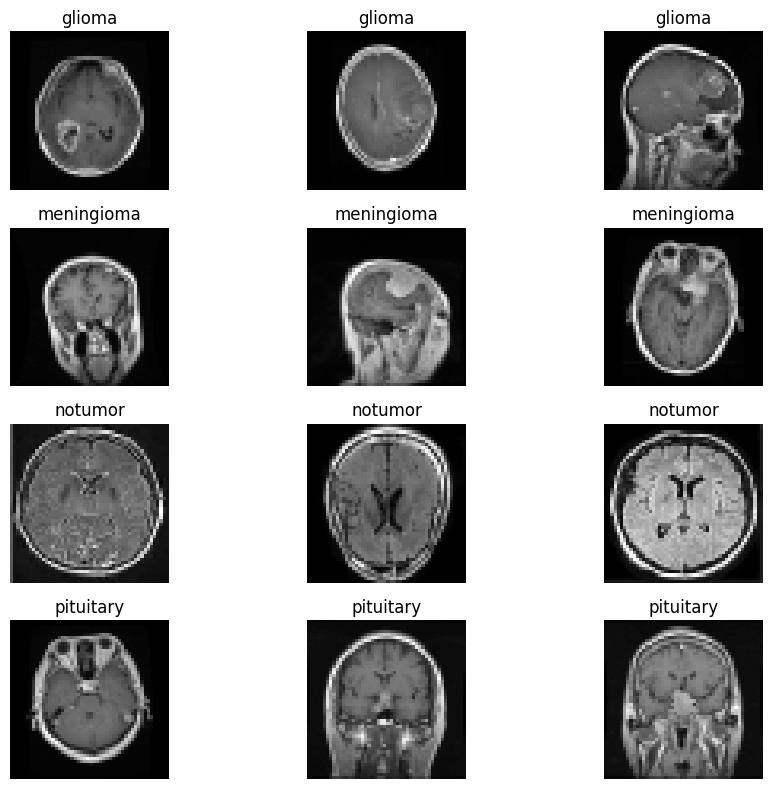

Extrayendo características de TRAIN...
Shape X_train_all: (5712, 922)
Extrayendo características de TEST (solo para evaluación final)...
Shape X_test_all: (1311, 922)
Clases: [np.str_('glioma'), np.str_('meningioma'), np.str_('notumor'), np.str_('pituitary')]


In [11]:
# -----------------------------------
# 3) (Basado EDA) y carga de datos
# -----------------------------------
# Basado en EDA: clases balanceadas moderadamente, diversas resoluciones,
# se normaliza y se usan features de textura (HOG/LBP) + stats.

if TRAIN_DIR.exists():
    show_examples(TRAIN_DIR, n_per_class=3)

print("Extrayendo características de TRAIN...")
X_train_all, y_train_all, train_paths = build_dataset(TRAIN_DIR)
print("Shape X_train_all:", X_train_all.shape)

print("Extrayendo características de TEST (solo para evaluación final)...")
X_test_all, y_test_all, test_paths = build_dataset(TEST_DIR)
print("Shape X_test_all:", X_test_all.shape)

# Codificar etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_all)
y_test_enc  = le.transform(y_test_all)
np.save(OUT_DIR / 'label_classes.npy', le.classes_)
print("Clases:", list(le.classes_))


In [12]:
# -----------------------------------------
# 4) Split de validación desde Training
# -----------------------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_all, y_train_enc,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train_enc
)
print("Split:", X_tr.shape, X_val.shape)

Split: (4569, 922) (1143, 922)


In [ ]:
# -----------------------------------------
# 5) Modelos + (GridSearchCV)
# -----------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Es posible seleccionar para el gridsearch la busqueda de hiperparametros en diferentes modelos
pipelines_grids = {
    'SVM-RBF': (
        Pipeline([
            ('scaler', StandardScaler(with_mean=False)),
            ('clf', SVC(probability=True, random_state=RANDOM_STATE))
        ]),
        {
            'clf__C': [0.1, 1, 10],
            'clf__gamma': ['scale', 0.01, 0.001]
        }
    )
    # ,
    # 'RandomForest': (
    #     Pipeline([
    #         ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
    #     ]),
    #     {
    #         'clf__n_estimators': [200, 400],
    #         'clf__max_depth': [None, 20, 40],
    #         'clf__min_samples_split': [2, 5]
    #     }
    # ),
    # 'LogReg': (
    #     Pipeline([
    #         ('scaler', StandardScaler()),
    #         ('clf', LogisticRegression(max_iter=2000, multi_class='ovr', random_state=RANDOM_STATE))
    #     ]),
    #     {
    #         'clf__C': [0.1, 1, 10],
    #         'clf__penalty': ['l2']
    #     }
    # )
}

In [14]:
# -----------------------------------------
# 6) Entrenamiento + validación con CV (con progreso)
# -----------------------------------------
import time
from datetime import timedelta

results = []
best_model = None
best_name = None
best_val_f1 = -1

total_models = len(pipelines_grids)
for idx, (name, (pipe, grid)) in enumerate(pipelines_grids.items(), 1):
    print(f"\n>>> [{idx}/{total_models}] Entrenando {name}")
    gridcv = GridSearchCV(pipe, grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1)

    t0 = time.time()
    if MLFLOW_AVAILABLE:
        mlflow.set_experiment("BrainTumor-ClassicML")
        with mlflow.start_run(run_name=name):
            gridcv.fit(X_tr, y_tr)
            y_pred_val = gridcv.predict(X_val)
            y_proba_val = gridcv.predict_proba(X_val)
            acc = accuracy_score(y_val, y_pred_val)
            f1  = f1_score(y_val, y_pred_val, average='macro')
            mlflow.log_metric("val_accuracy", float(acc))
            mlflow.log_metric("val_f1_macro", float(f1))
            mlflow.log_params(gridcv.best_params_)
            mlflow.sklearn.log_model(gridcv.best_estimator_, f"model_{name}")
    else:
        gridcv.fit(X_tr, y_tr)
        y_pred_val = gridcv.predict(X_val)
        y_proba_val = gridcv.predict_proba(X_val)
        acc = accuracy_score(y_val, y_pred_val)
        f1  = f1_score(y_val, y_pred_val, average='macro')

    elapsed = timedelta(seconds=time.time() - t0)
    print(f"[{name}] terminado en {elapsed}")
    print("   Best params:", gridcv.best_params_)
    print("   Val Accuracy:", acc, "Val F1-macro:", f1)

    results.append({'name': name, 'best_params': gridcv.best_params_,
                    'val_acc': float(acc), 'val_f1_macro': float(f1)})

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model = gridcv.best_estimator_
        best_name = name

with open(OUT_DIR / 'val_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\nMejor modelo:", best_name, "con F1-macro =", best_val_f1)



>>> [1/1] Entrenando SVM-RBF
Fitting 5 folds for each of 9 candidates, totalling 45 fits


Python(1926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1933) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/09/03 12:22:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Python(2057) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/09/03 12:23:03 

[SVM-RBF] terminado en 0:17:00.325337
   Best params: {'clf__C': 10, 'clf__gamma': 0.001}
   Val Accuracy: 0.9291338582677166 Val F1-macro: 0.9269190481906519

Mejor modelo: SVM-RBF con F1-macro = 0.9269190481906519


TEST Accuracy: 0.9588100686498856
TEST F1-macro: 0.9555492884547576

Reporte de clasificación:
              precision    recall  f1-score   support

      glioma       0.95      0.90      0.92       300
  meningioma       0.91      0.93      0.92       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



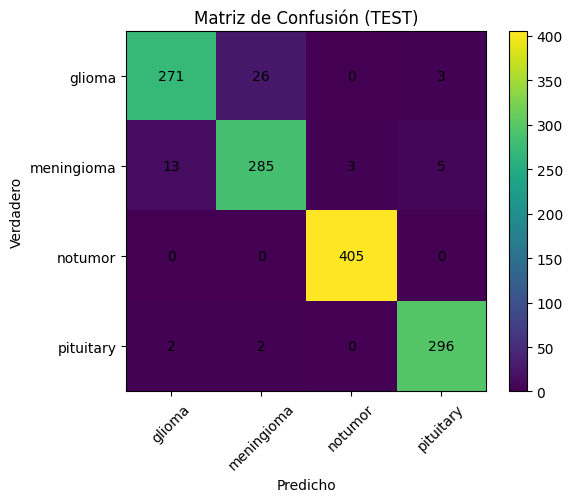

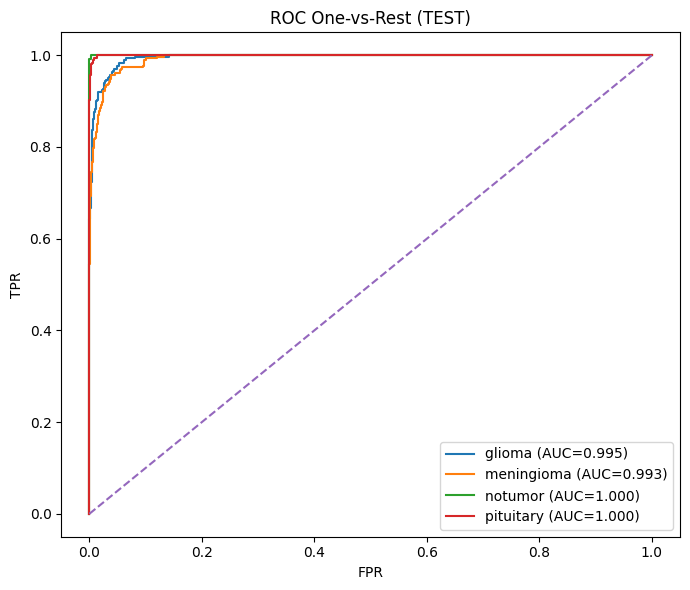

In [15]:
# -----------------------------------------
# 7) Evaluación en TEST oficial
# -----------------------------------------
from sklearn.preprocessing import label_binarize

best_model.fit(X_train_all, y_train_enc)  # reentrenar con todo TRAIN
y_test_pred = best_model.predict(X_test_all)
y_test_proba = best_model.predict_proba(X_test_all)

test_acc = accuracy_score(y_test_enc, y_test_pred)
test_f1  = f1_score(y_test_enc, y_test_pred, average='macro')

print("TEST Accuracy:", test_acc)
print("TEST F1-macro:", test_f1)
print("\nReporte de clasificación:")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de Confusión (TEST)')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

# ROC OvR
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))
plt.figure(figsize=(7,6))
for i, cls in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])
    plt.plot(fpr, tpr, label=f'{cls} (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC One-vs-Rest (TEST)')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# -----------------------------------------
# 8) Guardar modelo + inferencia
# -----------------------------------------
import joblib

MODEL_PATH = OUT_DIR / f'model_{best_name}.joblib'
SCALER_PATH = OUT_DIR / 'label_encoder.joblib'

joblib.dump(best_model, MODEL_PATH)
joblib.dump(le, SCALER_PATH)
print('Modelo guardado en', MODEL_PATH)
print('LabelEncoder guardado en', SCALER_PATH)

def predict_image(path_to_img):
    """Inferencia en 1 imagen; retorna (clase_predicha, confianza, dict_probs)."""
    model = joblib.load(MODEL_PATH)
    le_ = joblib.load(SCALER_PATH)
    img = preprocess_image(path_to_img)
    feat = extract_features(img).reshape(1, -1)
    proba = model.predict_proba(feat)[0]
    idx = np.argmax(proba)
    return le_.classes_[idx], float(proba[idx]), dict(zip(le_.classes_, proba.tolist()))

Modelo guardado en outputs_ml_brain_tumor/model_SVM-RBF.joblib
LabelEncoder guardado en outputs_ml_brain_tumor/label_encoder.joblib
